In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
from tqdm import tqdm_notebook 
from scipy.ndimage.morphology import binary_fill_holes

In [13]:
train = pd.read_csv('severstal_steel_defect_detection/train.csv')
ltrain = train.shape[0]

In [14]:
train['defect'] = train['EncodedPixels'].notnull()
train['ClassId'] = train['ImageId_ClassId'].str[-1:]
train['ImageId'] = train['ImageId_ClassId'].str[:-2]
train = train[['ImageId','ClassId','defect','EncodedPixels']]

In [15]:
train_def = train.groupby(['ImageId'])['defect'].sum().astype('uint8').to_frame(name='NumDef').reset_index()

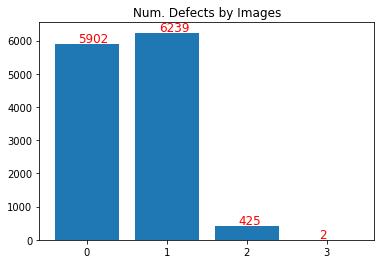

In [16]:
labels, counts = np.unique(train_def.NumDef, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.gca().set_title('Num. Defects by Images')
for i in range(len(counts)):
    plt.text(x = i-0.1 , y = counts[i]+50, s = counts[i], size = 12, color='r')
plt.show()

In [17]:
train = train[train.defect]

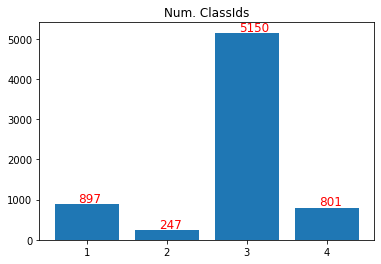

In [18]:
labels, counts = np.unique(train.ClassId, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.gca().set_title('Num. ClassIds')
for i in range(len(counts)):
    plt.text(x = i-0.1 , y = counts[i]+50, s = counts[i], size = 12, color='r')
plt.show()

In [19]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [20]:
# Test RLE functions
mask2rle(rle2mask(train['EncodedPixels'].iloc[1]))==train['EncodedPixels'].iloc[1]

True

In [21]:
def dice_coef(y_true, y_pred, smooth=1e-9  ):
    y_true_f = y_true.reshape(-1,1)
    y_pred_f = y_pred.reshape(-1,1)
    intersection = np.sum( y_true_f * y_pred_f )
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth) 

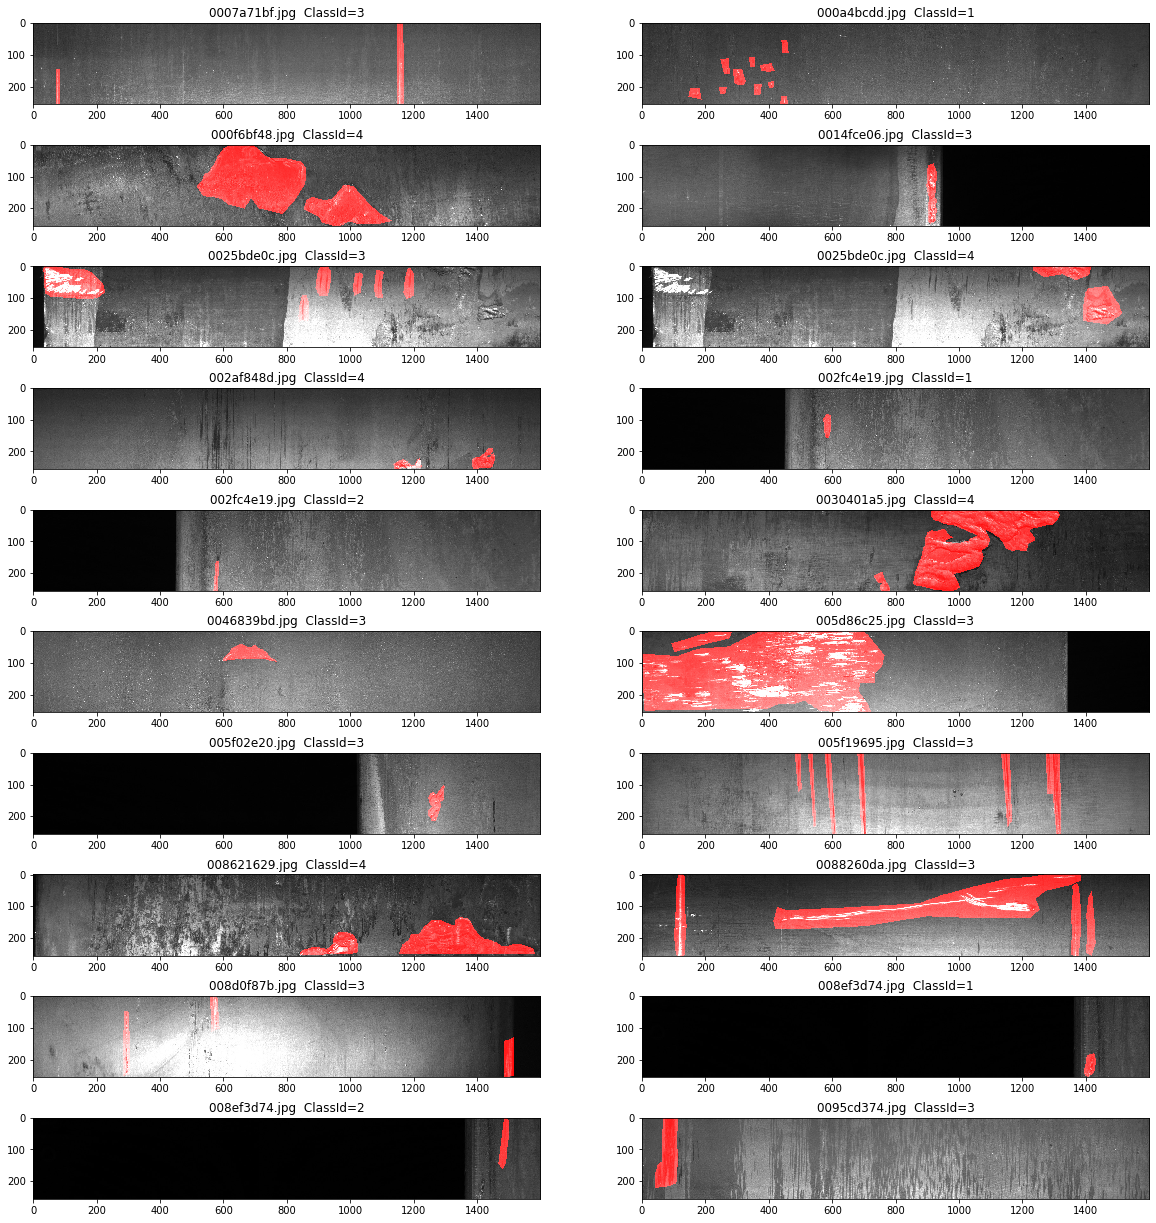

In [23]:
# View Masks and Classes
columns = 2
rows = 10
fig = plt.figure(figsize=(20,columns*rows+2))
for i in range(1,columns*rows+1):
    fn = train['ImageId'].iloc[i]
    c = train['ClassId'].iloc[i]
    fig.add_subplot(rows, columns, i).set_title(fn+"  ClassId="+c)
    img = cv2.imread( 'severstal_steel_defect_detection/train_images/'+fn )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask(train['EncodedPixels'].iloc[i])
    img[mask==1,0] = 255
    plt.imshow(img)
plt.show()

In [24]:
element = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))

def getmask(path, fn, d=30):
    img = cv2.imread( path+fn )
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_img = cv2.equalizeHist(gray_img)
    ret,thresh = cv2.threshold(gray_img,254,255,cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(thresh, contours, -1, (255,255,255), 3)
    thresh = cv2.erode(thresh, element, iterations = 4)
    thresh = cv2.dilate(thresh, element, iterations = d)
    thresh = binary_fill_holes(thresh).astype('uint8')
    return thresh

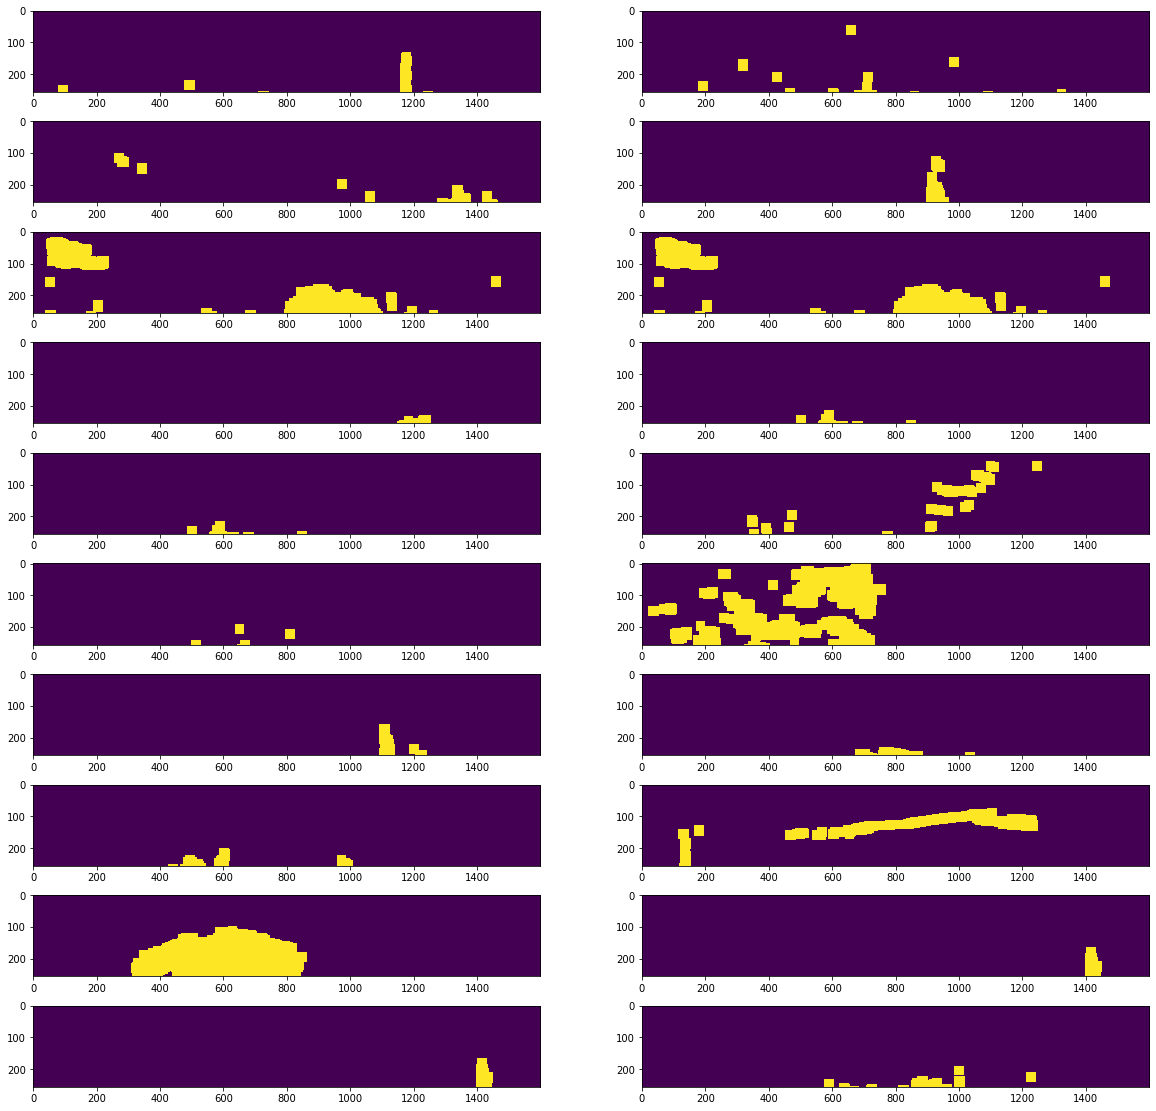

In [27]:
columns = 2
rows = 10
fig=plt.figure(figsize=(20,columns*rows))
for i in range(1,columns*rows+1):
    fig.add_subplot(rows, columns, i)
    fn = train['ImageId'].iloc[i]
    plt.imshow(getmask('severstal_steel_defect_detection/train_images/',fn))
plt.show()

In [29]:
dice=[]
for i in tqdm_notebook(range( train.shape[0] )):
    if train['ClassId'].iloc[i]=='3':
        mask = rle2mask( train['EncodedPixels'].iloc[i]).astype(np.float64)
        fn = train['ImageId'].iloc[i]
        dice.append( dice_coef( mask, getmask('severstal_steel_defect_detection/train_images/', fn, d=30) ) )

print( 'Dice ClassId=3 on train:', np.mean(dice) )


Dice ClassId=3 on train: 0.16110507853672046


In [30]:
sub = pd.read_csv( 'severstal_steel_defect_detection/sample_submission.csv' )
sub['EncodedPixels']  = ''

In [33]:
for i in range( sub.shape[0] ):
    c =  sub['ImageId_ClassId'].str[-1:].iloc[i]
    fn = sub['ImageId_ClassId'].str[:-2].iloc[i]
    if c=='3':
        sub['EncodedPixels'].iloc[i] = mask2rle(getmask('severstal_steel_defect_detection/test_images/', fn))

In [36]:
sub.to_csv('severstal_steel_defect_detection/submission.csv', index=False)

In [44]:
# import os

# count = 0
# path = r'severstal_steel_defect_detection/test_images'
# for root, dirs, files in os.walk(path):
#     fileLength = len(files)
#     if fileLength != 0:
#         count = count + fileLength
# print(count*4)

7204


In [45]:
# len(sub)

7204